# Imports

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

SENTIMENT_PATH = '/content/fear_greed_index.csv'
TRADES_PATH = '/content/historical_data.csv'



# Data loading

In [7]:
def load_data():
    print("--- Loading Datasets ---")
    df_sent = pd.read_csv(SENTIMENT_PATH)
    df_sent['Date'] = pd.to_datetime(df_sent['date'])
    df_sent = df_sent[['Date', 'value', 'classification']].rename(columns={'value': 'Sentiment_Score', 'classification': 'Sentiment_Class'})

    df_trades = pd.read_csv(TRADES_PATH)
    df_trades['datetime'] = pd.to_datetime(df_trades['Timestamp'], unit='ms')
    df_trades['Date'] = df_trades['datetime'].dt.normalize()

    # Merge
    df = pd.merge(df_trades, df_sent, on='Date', how='inner')
    df['is_winner'] = df['Closed PnL'] > 0
    return df

# Insights

In [8]:
def engineer_features(df):
    print("--- Engineering Advanced Features ---")

    # Whale Definition: Top 10% of trade sizes
    whale_threshold = df['Size USD'].quantile(0.90)
    df['Trader_Type'] = np.where(df['Size USD'] >= whale_threshold, 'Whale', 'Retail')
    print(f"   > Whale Threshold: ${whale_threshold:.2f}+")

    #   Profit Factor Helper Columns
    df['Gross_Profit'] = df['Closed PnL'].apply(lambda x: x if x > 0 else 0)
    df['Gross_Loss'] = df['Closed PnL'].apply(lambda x: abs(x) if x < 0 else 0)

    return df


def run_advanced_analysis(df):
    print("\n--- Running Advanced Segmentation ---")

    #       Whale vs Retail Performance per Sentiment
    # We want to see if Whales are smarter during 'Extreme Fear'
    cohort_summary = df.groupby(['Sentiment_Class', 'Trader_Type']).agg({
        'Closed PnL': 'mean',
        'is_winner': 'mean',
        'Gross_Profit': 'sum',
        'Gross_Loss': 'sum'
    }).reset_index()

    # Calculate Profit Factor (Profit / Loss)

    cohort_summary['Profit_Factor'] = cohort_summary['Gross_Profit'] / cohort_summary['Gross_Loss'].replace(0, 1)

    # Sort for readability
    print("\n[WHALE VS RETAIL PERFORMANCE]")
    print(cohort_summary[['Sentiment_Class', 'Trader_Type', 'Closed PnL', 'is_winner', 'Profit_Factor']].sort_values('Sentiment_Class'))

    # Insight 2: Directional Bias (Long vs Short in Fear)
    # Assuming 'Side' = BUY (Long) and SELL (Short)
    direction_summary = df.groupby(['Sentiment_Class', 'Side']).agg({
        'Closed PnL': 'mean',
        'Size USD': 'count' # Volume
    }).reset_index()

    return cohort_summary, direction_summary


# Visualization

In [9]:
def plot_advanced(cohort_df, direction_df):
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    sns.barplot(
        data=cohort_df,
        x='Sentiment_Class',
        y='Profit_Factor',
        hue='Trader_Type',
        ax=axes[0],
        palette='magma'
    )
    axes[0].set_title('Profit Factor: Whales vs. Retail', fontsize=14)
    axes[0].axhline(1.0, color='red', linestyle='--', label='Break-Even (1.0)')
    axes[0].set_ylabel('Profit Factor (>1.0 is Profitable)')
    axes[0].legend(title='Trader Type')

    sns.barplot(
        data=direction_df,
        x='Sentiment_Class',
        y='Size USD',
        hue='Side',
        ax=axes[1],
        palette='viridis'
    )
    axes[1].set_title('Buying vs. Selling Volume by Sentiment', fontsize=14)
    axes[1].set_ylabel('Trade Count')

    plt.tight_layout()
    plt.savefig('advanced_trader_insights.png')
    print("\nCharts saved as 'advanced_trader_insights.png'")
    plt.show()


--- Loading Datasets ---
--- Engineering Advanced Features ---
   > Whale Threshold: $8279.50+

--- Running Advanced Segmentation ---

[WHALE VS RETAIL PERFORMANCE]
  Sentiment_Class Trader_Type  Closed PnL  is_winner  Profit_Factor
0   Extreme Greed      Retail   17.819234   0.526965       6.413437
1   Extreme Greed       Whale   58.896860   0.327640       2.241753
2            Fear      Retail   18.071151   0.417854       5.152350
3            Fear       Whale  338.772542   0.390695       6.491324
4           Greed      Retail   41.670954   0.452588      20.673668
5           Greed       Whale  584.349472   0.380783       5.087880
6         Neutral      Retail   18.829982   0.307095       4.246329
7         Neutral       Whale   53.512089   0.410000       1.294281

Charts saved as 'advanced_trader_insights.png'


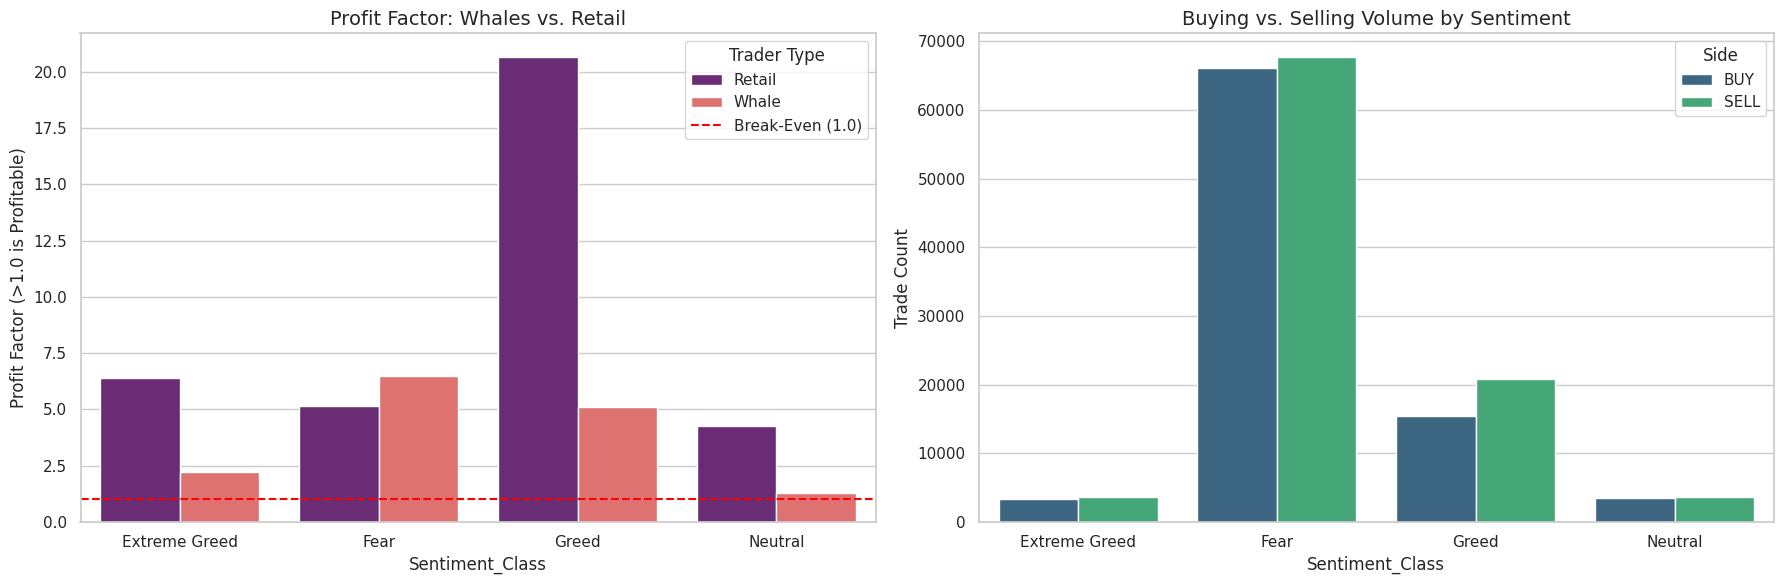

In [10]:
if __name__ == "__main__":
    df = load_data()
    df = engineer_features(df)
    cohort_stats, dir_stats = run_advanced_analysis(df)
    plot_advanced(cohort_stats, dir_stats)

    cohort_stats.to_csv('whale_retail_analysis.csv', index=False)